In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

#Reading the data
df = pd.read_csv('/Users/erenozbek/Desktop/KocPython2021/Churn_Modelling.csv')
df.shape

(10000, 14)

In [2]:
# Drop the columns that are personal and irrelevant for prediction
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

# Train Test Split and Imputer

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=0., strategy='mean')

# Adding new parameters that can be useful for the estimation

#Salary by age is likely to be an indicator of a customer's socio-economic status
df['SalaryAgeRatio'] = df.EstimatedSalary/(df.Age)

# Credit score given the salary shows the spending behaviour and willingness to save
df['CreditScoreSalaryRatio'] = df.CreditScore/(df.EstimatedSalary)

# How much a customer is willing to save
df['BalanceSalaryRatio'] = df.Balance/(df.EstimatedSalary)

#Does a customer leave after the credit payment or stay within the bank system
TenureF = imputer.fit_transform(df[['Tenure']])
BalanceF = imputer.fit_transform(df[['Balance']])
df['TenureBalanceRatio'] = TenureF/BalanceF

df_train, df_test = train_test_split(df, test_size= 0.2,
random_state=1)



In [3]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'SalaryAgeRatio',
                   'CreditScoreSalaryRatio','BalanceSalaryRatio', 'TenureBalanceRatio']
categorical_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + categorical_vars]
df_test = df_test[['Exited'] + continuous_vars + categorical_vars]

'''Replacing 0 with -1 for two kind of one-hot variables so that the effect will be negative '''

df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1

df_test.loc[df_test.HasCrCard == 0, 'HasCrCard'] = -1
df_test.loc[df_test.IsActiveMember == 0, 'IsActiveMember'] = -1

# One hot encoding for Geography and Gender

lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    for j in df_train[i].unique():
        df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        df_test[i+'_'+j] = np.where(df_test[i] == j,1,-1)
    remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_test = df_test.drop(remove, axis=1)

## Explarotary Data Analysis

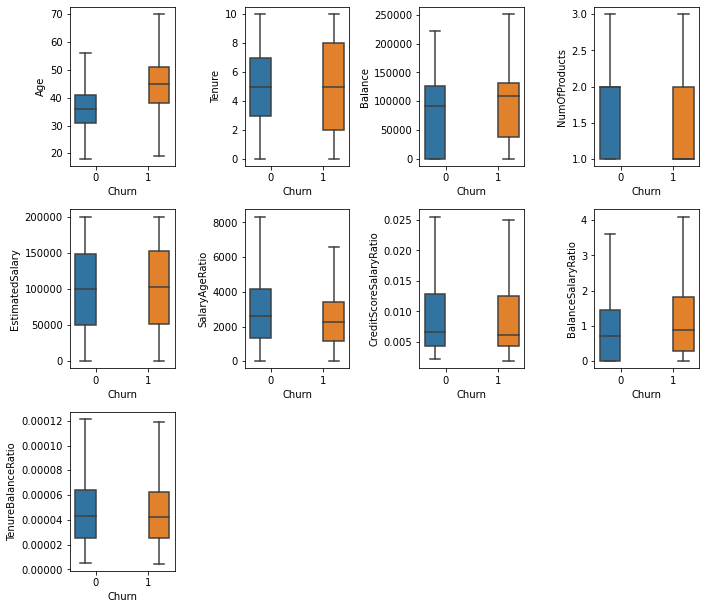

In [4]:
df2 = df.rename(columns = {'Exited': 'Churn'}, inplace = False)
plot_columns = df2.drop(['Churn','Gender','Geography','IsActiveMember','HasCrCard'], axis = 1).columns
fig = plt.figure(figsize=(10, 18))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    k=sns.boxplot(x='Churn',y=plot_columns[i],hue='Churn', showfliers=False,data=df2)
    l = plt.legend([],[], frameon=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig("churn.png")

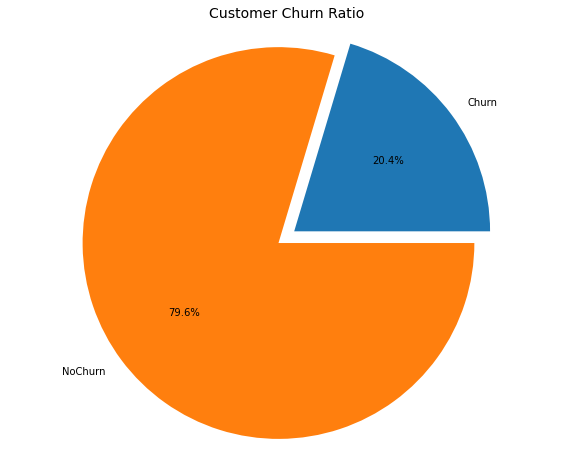

In [5]:
labels = 'Churn', 'NoChurn'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Customer Churn Ratio", size = 14)
plt.savefig('churnratio.png')
plt.show()

In [6]:
#Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train[continuous_vars] = scaler.fit_transform(df_train[continuous_vars])
df_test[continuous_vars] = scaler.fit_transform(df_test[continuous_vars])


from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Scoring functions
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Function to give best model score and parameters
def best_model(model):
    print('Here is the best score for the model: ', model.best_score_)    
    print('Here are the best parameters for the model: ', model.best_params_)
    print('Here are the best estimators for the model: ', model.best_estimator_)

In [12]:
# Logistic Regression
lgr = LogisticRegression()
grid_lgr = GridSearchCV(lgr, {'C':[0.00001, 0.0001 ,0.001, 0.01, 0.1, 1, 10]}, cv=20)
df_pred = grid_lgr.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited).predict(df_test.loc[:, df_test.columns != 'Exited'])
best_model(grid_lgr)
print('Here is the accuracy score: ', accuracy_score(df_test.Exited, df_pred))
print(classification_report(df_test.Exited, df_pred))
print('Here are the cross validation scores: ', cross_val_score(grid_lgr ,df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited, cv=5) )


Here is the best score for the model:  0.813375
Here are the best parameters for the model:  {'C': 0.1}
Here are the best estimators for the model:  LogisticRegression(C=0.1)
Here is the accuracy score:  0.815
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1585
           1       0.67      0.22      0.33       415

    accuracy                           0.81      2000
   macro avg       0.75      0.59      0.61      2000
weighted avg       0.79      0.81      0.78      2000

Here are the cross validation scores:  [0.814375 0.824375 0.809375 0.806875 0.81125 ]


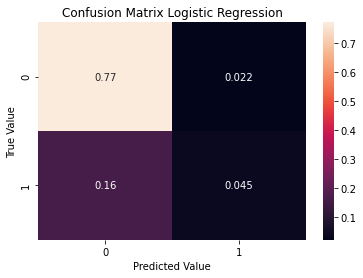

In [8]:
#Confusion matrix for Logistic Regression
cm_lgr = confusion_matrix(df_test.Exited, df_pred)
possibilities = cm_lgr/np.sum(cm_lgr)
sns.heatmap(possibilities, annot=True, cbar=True, cmap='rocket')
plt.title('Confusion Matrix Logistic Regression')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [13]:
# Fit logistic regression with pol 2 kernel
poly2 = PolynomialFeatures(degree=2, include_bias=False)
df_train_pol2 = poly2.fit_transform(df_train.loc[:, df_train.columns != 'Exited'])
df_test_pol2 = poly2.fit_transform(df_test.loc[:, df_test.columns != 'Exited'])
log_p2 = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=300, n_jobs=None, 
                              penalty='l2', random_state=None, solver='liblinear',tol=0.0001, verbose=0, warm_start=False)
df_pred_pol_2p = log_p2.fit(df_train_pol2,df_train.Exited).predict(df_test_pol2)
print('Here is the accuracy score: ', accuracy_score(df_test.Exited, df_pred_pol_2p))
print(classification_report(df_test.Exited, df_pred_pol_2p))

Here is the accuracy score:  0.856
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1585
           1       0.73      0.49      0.58       415

    accuracy                           0.86      2000
   macro avg       0.80      0.72      0.75      2000
weighted avg       0.85      0.86      0.84      2000



In [17]:
# Fit SVM with Pol Kernel
SVM_POL = SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,  decision_function_shape='ovr', degree=2, gamma=0.1, kernel='poly',  max_iter=-1,)
SVM_pred = SVM_POL.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited).predict(df_test.loc[:, df_test.columns != 'Exited'])
print('Here is the accuracy score: ', accuracy_score(df_test.Exited, SVM_pred))
print(classification_report(df_test.Exited, SVM_pred))
print('Here are the cross validation scores: ', cross_val_score(SVM_POL ,df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited, cv=5) )



Here is the accuracy score:  0.8605
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1585
           1       0.83      0.41      0.55       415

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000

Here are the cross validation scores:  [0.859375 0.858125 0.84625  0.85375  0.84875 ]


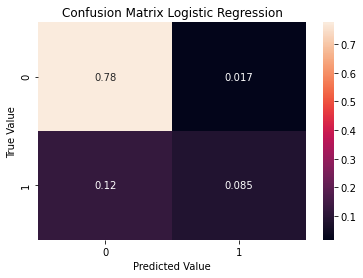

In [18]:
#Confusion Matrix for SVM with Pol Kernel
cm_lgr = confusion_matrix(df_test.Exited, SVM_pred)
possibilities = cm_lgr/np.sum(cm_lgr)
sns.heatmap(possibilities, annot=True, cbar=True, cmap='rocket')
plt.title('Confusion Matrix Logistic Regression')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

In [20]:
# Random Forest classifier
RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',max_depth=8, max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1, min_samples_split=3,min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None, oob_score=False, random_state=None, verbose=0,warm_start=False)
RF_pred = RF.fit(df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited).predict(df_test.loc[:, df_test.columns != 'Exited'])
print('Here is the accuracy score: ', accuracy_score(df_test.Exited, RF_pred))
print('Here is the classification report: ', classification_report(df_test.Exited, RF_pred))
print('Here are the cross validation scores: ', cross_val_score(RF,df_train.loc[:, df_train.columns != 'Exited'],df_train.Exited, cv=5) )



Here is the accuracy score:  0.8645
Here is the classification report:                precision    recall  f1-score   support

           0       0.87      0.98      0.92      1585
           1       0.85      0.42      0.56       415

    accuracy                           0.86      2000
   macro avg       0.86      0.70      0.74      2000
weighted avg       0.86      0.86      0.85      2000

Here are the cross validation scores:  [0.8675   0.863125 0.85     0.861875 0.85625 ]


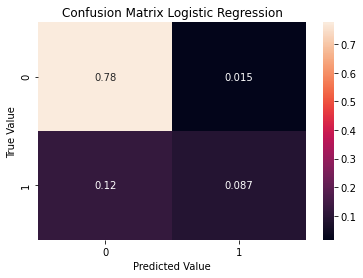

In [22]:
#Confusion Matrix for RF classifier
cm_lgr = confusion_matrix(df_test.Exited, RF_pred)
possibilities = cm_lgr/np.sum(cm_lgr)
sns.heatmap(possibilities, annot=True, cbar=True, cmap='rocket')
plt.title('Confusion Matrix Logistic Regression')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()